In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
import fenics as fe

from tqdm import trange
from numpy.testing import assert_allclose

import sys

sys.path.insert(0, "../scripts")

from swe_2d import ShallowTwo, ShallowTwoFilter
from statfenics.utils import build_observation_operator

fe.set_log_level(50)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# physical constants
period = 120.
nu = 1e-6
g = 9.8

# reference values
u_ref = 0.01  # cm/s
length_ref = 0.1  # cylinder
time_ref = length_ref / u_ref
H_ref = length_ref

# compute reynolds number
Re = u_ref * length_ref / nu

params = dict(
    nu=1 / Re,
    g=g * H_ref / u_ref**2,
    C=0.,
    H=0.053 / H_ref,
    u_inflow=0.004 / u_ref,
    inflow_period=period / time_ref)
control = dict(
    dt=5e-2,
    theta=0.5,
    simulation="cylinder",
    use_imex=False,
    use_les=False)
sigma_y = 0.05 * params["u_inflow"]

comm = fe.MPI.comm_world
mesh = "../mesh/branson-mesh-nondim.xdmf"
swe = ShallowTwoFilter(mesh, params, control, comm)
assert swe.L == 20.
assert swe.B == 5.

# check that all the dofs line up
assert_allclose(np.unique(swe.W.dofmap().dofs()),
                np.unique(np.concatenate((swe.u_dofs,
                                          swe.v_dofs,
                                          swe.h_dofs))))
swe.setup_form()
swe.setup_solver()

(191, 2)


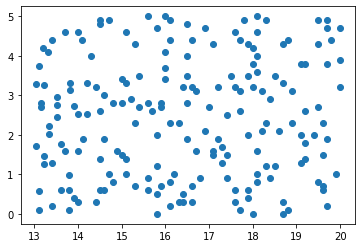

In [3]:
data_file = "../data/run-8-synthetic-data-nondim.h5"

with h5py.File(data_file, "r") as f:
    t_data = f["t"][:]
    x_data = f["x"][:]
    u_data = f["u"][:]
    v_data = f["v"][:]
    
mask_obs = x_data[:, 0] >= 13.
x_obs = x_data[mask_obs, :][::20]
print(x_obs.shape)

plt.plot(x_obs[:, 0], x_obs[:, 1], "o")
Hu = build_observation_operator(x_obs, swe.W, sub=(0, 0))
Hv = build_observation_operator(x_obs, swe.W, sub=(0, 1))

In [4]:
from scipy.sparse import vstack

H = vstack((Hu, Hv))
print(H.shape)

(382, 140763)


In [5]:
# setup filter (basically compute prior additive noise covariance)
# approx 1% process error, lengthscales approx 2 cylinder diams
rho = 5e-2
ell = 2.
k = 64
stat_params = dict(rho_u=rho, rho_v=rho, rho_h=0.,
                   ell_u=ell, ell_v=ell, ell_h=0.5,
                   k_init_u=k, k_init_v=k, k_init_h=1, k=2*k,
                   sigma_y=sigma_y, H=H)
swe.setup_filter(stat_params)

# as on the same fcn space
assert_allclose(swe.Ku_vals, swe.Kv_vals)

[2.33290630e-02 2.31655441e-02 1.28117436e-02 1.24107076e-02
 4.80448101e-03 4.39513511e-03 2.29615434e-03 2.18739174e-03
 1.43843101e-03 1.28924479e-03 1.20253125e-03 1.03312528e-03
 6.38324634e-04 4.43883017e-04 2.79473366e-04 1.96445374e-04
 1.62806082e-04 1.10098661e-04 5.82713152e-05 4.20231623e-05
 4.14404717e-05 3.99686914e-05 2.33503697e-05 2.09841588e-05
 1.83711168e-05 1.70765846e-05 9.18274527e-06 7.98968109e-06
 5.96327473e-06 5.23521226e-06 2.09427712e-06 2.06584034e-06
 1.50365468e-06 1.13782229e-06 5.88735102e-07 5.32174165e-07
 3.05105620e-07 1.84109808e-07 1.68481969e-07 1.68221455e-07
 1.56540581e-07 9.48657701e-08 9.08442392e-08 6.48138821e-08
 4.41585094e-08 3.30686858e-08 3.24505859e-08 3.12680696e-08
 2.74215604e-08 1.40905549e-08 9.37607300e-09 8.69972382e-09
 7.38250055e-09 3.20457761e-09 2.21783072e-09 1.77129621e-09
 1.30143245e-09 1.28834477e-09 1.26452111e-09 6.21791995e-10
 2.80572833e-10 2.47261228e-10 1.66997283e-10 1.39573236e-10]
[2.33290630e-02 2.31655

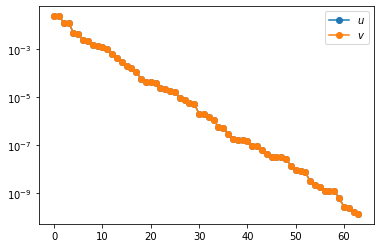

In [6]:
plt.semilogy(swe.Ku_vals, "o-", label="$u$")
plt.semilogy(swe.Kv_vals, "o-", label="$v$")
plt.legend()
plt.show()

In [ ]:
t = 0.
t_final = 2. * period / time_ref
nt = np.int32(np.round(t_final / control["dt"]))
nt_obs = len([i for i in range(nt) if i % 2 == 0])

means = np.zeros((nt, swe.mean.shape[0]))
variances = np.zeros((nt, swe.mean.shape[0]))
lml = np.zeros((nt_obs, ))

i_dat = 0
for i in trange(nt):
    t += swe.dt
    swe.inlet_velocity.t = t
    swe.prediction_step(t)
    
    if i % 2 == 0:
        assert np.isclose(t_data[i_dat], t)
        y_obs = np.concatenate((u_data[i_dat, mask_obs][::20], 
                                v_data[i_dat, mask_obs][::20]))
        lml[i_dat] = swe.update_step(y_obs, compute_lml=True)
        print(
            np.linalg.norm(y_obs - H @ swe.du.vector().get_local()) 
            / np.sqrt(len(y_obs)))
        i_dat += 1
        
    swe.set_prev()

  0%|                                                                                                                   | 0/480 [00:00<?, ?it/s]

Prop. variance kept in the reduction: 1.000000


  0%|▏                                                                                                        | 1/480 [00:19<2:34:24, 19.34s/it]

0.019527337682997487
Prop. variance kept in the reduction: 0.999990


  0%|▍                                                                                                        | 2/480 [00:36<2:25:24, 18.25s/it]

Prop. variance kept in the reduction: 0.999896


  1%|▋                                                                                                        | 3/480 [00:54<2:24:14, 18.14s/it]

0.02119634472714331
Prop. variance kept in the reduction: 0.999825


  1%|▉                                                                                                        | 4/480 [01:12<2:21:56, 17.89s/it]

Prop. variance kept in the reduction: 0.999798


  1%|█                                                                                                        | 5/480 [01:30<2:21:57, 17.93s/it]

0.02043088949166251
Prop. variance kept in the reduction: 0.999782


  1%|█▎                                                                                                       | 6/480 [01:47<2:20:20, 17.77s/it]

Prop. variance kept in the reduction: 0.999770


  1%|█▌                                                                                                       | 7/480 [02:05<2:20:33, 17.83s/it]

0.019244121732792226
Prop. variance kept in the reduction: 0.999753


  2%|█▊                                                                                                       | 8/480 [02:23<2:19:16, 17.71s/it]

Prop. variance kept in the reduction: 0.999726


  2%|█▉                                                                                                       | 9/480 [02:41<2:19:46, 17.81s/it]

0.01941426841953882
Prop. variance kept in the reduction: 0.999700


  2%|██▏                                                                                                     | 10/480 [02:59<2:19:34, 17.82s/it]

Prop. variance kept in the reduction: 0.999670


  2%|██▍                                                                                                     | 11/480 [03:17<2:19:39, 17.87s/it]

0.01988184229441972
Prop. variance kept in the reduction: 0.999641


  2%|██▌                                                                                                     | 12/480 [03:34<2:18:26, 17.75s/it]

Prop. variance kept in the reduction: 0.999608


  3%|██▊                                                                                                     | 13/480 [03:52<2:18:41, 17.82s/it]

0.019742670894403392
Prop. variance kept in the reduction: 0.999576


  3%|███                                                                                                     | 14/480 [04:09<2:17:34, 17.71s/it]

Prop. variance kept in the reduction: 0.999549


  3%|███▎                                                                                                    | 15/480 [04:27<2:17:54, 17.80s/it]

0.02001698610919726
Prop. variance kept in the reduction: 0.999514


  3%|███▍                                                                                                    | 16/480 [04:45<2:16:51, 17.70s/it]

Prop. variance kept in the reduction: 0.999492


  4%|███▋                                                                                                    | 17/480 [05:03<2:17:15, 17.79s/it]

0.019953616788730127
Prop. variance kept in the reduction: 0.999446


  4%|███▉                                                                                                    | 18/480 [05:20<2:16:13, 17.69s/it]

Prop. variance kept in the reduction: 0.999408


  4%|████                                                                                                    | 19/480 [05:38<2:16:40, 17.79s/it]

0.020615730668758343
Prop. variance kept in the reduction: 0.999356


  4%|████▎                                                                                                   | 20/480 [05:56<2:15:44, 17.70s/it]

Prop. variance kept in the reduction: 0.999328


  4%|████▌                                                                                                   | 21/480 [06:14<2:16:03, 17.78s/it]

0.02005655625687951
Prop. variance kept in the reduction: 0.999273


  5%|████▊                                                                                                   | 22/480 [06:31<2:15:03, 17.69s/it]

Prop. variance kept in the reduction: 0.999230


  5%|████▉                                                                                                   | 23/480 [06:49<2:15:29, 17.79s/it]

0.0196334756057866
Prop. variance kept in the reduction: 0.999171


  5%|█████▏                                                                                                  | 24/480 [07:07<2:14:25, 17.69s/it]

Prop. variance kept in the reduction: 0.999119


  5%|█████▍                                                                                                  | 25/480 [07:25<2:14:45, 17.77s/it]

0.021539324257258637
Prop. variance kept in the reduction: 0.999036


  5%|█████▋                                                                                                  | 26/480 [07:42<2:13:43, 17.67s/it]

Prop. variance kept in the reduction: 0.999004


  6%|█████▊                                                                                                  | 27/480 [08:00<2:14:00, 17.75s/it]

0.020519422443411928
Prop. variance kept in the reduction: 0.998958


  6%|██████                                                                                                  | 28/480 [08:18<2:13:02, 17.66s/it]

Prop. variance kept in the reduction: 0.998926


  6%|██████▎                                                                                                 | 29/480 [08:36<2:13:27, 17.76s/it]

0.019074464950798477
Prop. variance kept in the reduction: 0.998868


  6%|██████▌                                                                                                 | 30/480 [08:53<2:12:37, 17.68s/it]

Prop. variance kept in the reduction: 0.998825


  6%|██████▋                                                                                                 | 31/480 [09:11<2:12:50, 17.75s/it]

0.020611246839001146
Prop. variance kept in the reduction: 0.998755


  7%|██████▉                                                                                                 | 32/480 [09:29<2:12:00, 17.68s/it]

Prop. variance kept in the reduction: 0.998707


  7%|███████▏                                                                                                | 33/480 [09:47<2:12:24, 17.77s/it]

0.019163395604203177
Prop. variance kept in the reduction: 0.998634


  7%|███████▎                                                                                                | 34/480 [10:04<2:11:26, 17.68s/it]

Prop. variance kept in the reduction: 0.998574


  7%|███████▌                                                                                                | 35/480 [10:22<2:11:58, 17.79s/it]

0.018743430426519665
Prop. variance kept in the reduction: 0.998567


  8%|███████▊                                                                                                | 36/480 [10:40<2:11:07, 17.72s/it]

Prop. variance kept in the reduction: 0.998478


  8%|████████                                                                                                | 37/480 [10:58<2:11:24, 17.80s/it]

0.020050482237278826
Prop. variance kept in the reduction: 0.998437


  8%|████████▏                                                                                               | 38/480 [11:15<2:10:24, 17.70s/it]

Prop. variance kept in the reduction: 0.998406


  8%|████████▍                                                                                               | 39/480 [11:33<2:10:52, 17.81s/it]

0.01965992722000086
Prop. variance kept in the reduction: 0.998340


  8%|████████▋                                                                                               | 40/480 [11:51<2:09:55, 17.72s/it]

Prop. variance kept in the reduction: 0.998299


  9%|████████▉                                                                                               | 41/480 [12:09<2:10:21, 17.82s/it]

0.02024701389032086
Prop. variance kept in the reduction: 0.998194


  9%|█████████                                                                                               | 42/480 [12:26<2:09:25, 17.73s/it]

Prop. variance kept in the reduction: 0.998182


  9%|█████████▎                                                                                              | 43/480 [12:44<2:09:50, 17.83s/it]

0.020509520046716873
Prop. variance kept in the reduction: 0.998145


  9%|█████████▌                                                                                              | 44/480 [13:02<2:08:52, 17.73s/it]

Prop. variance kept in the reduction: 0.998124


  9%|█████████▊                                                                                              | 45/480 [13:20<2:09:14, 17.83s/it]

0.0192427826397412
Prop. variance kept in the reduction: 0.998173


 10%|█████████▉                                                                                              | 46/480 [13:37<2:08:16, 17.73s/it]

Prop. variance kept in the reduction: 0.998145


 10%|██████████▏                                                                                             | 47/480 [13:55<2:08:39, 17.83s/it]

0.020924557177980526
Prop. variance kept in the reduction: 0.998102


 10%|██████████▍                                                                                             | 48/480 [14:13<2:07:44, 17.74s/it]

Prop. variance kept in the reduction: 0.998073


 10%|██████████▌                                                                                             | 49/480 [14:31<2:08:07, 17.84s/it]

0.019047317218355432
Prop. variance kept in the reduction: 0.998024


 10%|██████████▊                                                                                             | 50/480 [14:48<2:07:09, 17.74s/it]

Prop. variance kept in the reduction: 0.998053


 11%|███████████                                                                                             | 51/480 [15:07<2:07:31, 17.84s/it]

0.020209637674614946
Prop. variance kept in the reduction: 0.998014


 11%|███████████▎                                                                                            | 52/480 [15:24<2:06:34, 17.74s/it]

Prop. variance kept in the reduction: 0.998053


 11%|███████████▍                                                                                            | 53/480 [15:42<2:06:55, 17.83s/it]

0.020239102799282416
Prop. variance kept in the reduction: 0.998023


 11%|███████████▋                                                                                            | 54/480 [16:00<2:05:58, 17.74s/it]

Prop. variance kept in the reduction: 0.998061


 11%|███████████▉                                                                                            | 55/480 [16:18<2:06:21, 17.84s/it]

0.020470782533720505
Prop. variance kept in the reduction: 0.997994


 12%|████████████▏                                                                                           | 56/480 [16:35<2:05:23, 17.74s/it]

Prop. variance kept in the reduction: 0.998021


 12%|████████████▎                                                                                           | 57/480 [16:53<2:05:45, 17.84s/it]

0.01962466505336334
Prop. variance kept in the reduction: 0.997954


 12%|████████████▌                                                                                           | 58/480 [17:11<2:04:47, 17.74s/it]

Prop. variance kept in the reduction: 0.997992


 12%|████████████▊                                                                                           | 59/480 [17:29<2:05:13, 17.85s/it]

0.019526989299479183
Prop. variance kept in the reduction: 0.997952


 12%|█████████████                                                                                           | 60/480 [17:46<2:04:21, 17.77s/it]

Prop. variance kept in the reduction: 0.997992


 13%|█████████████▏                                                                                          | 61/480 [18:05<2:04:39, 17.85s/it]

0.01932981456738531
Prop. variance kept in the reduction: 0.997971


 13%|█████████████▍                                                                                          | 62/480 [18:22<2:03:43, 17.76s/it]

Prop. variance kept in the reduction: 0.998001


 13%|█████████████▋                                                                                          | 63/480 [18:40<2:04:02, 17.85s/it]

0.019753035226862375
Prop. variance kept in the reduction: 0.997969


 13%|█████████████▊                                                                                          | 64/480 [18:58<2:03:03, 17.75s/it]

Prop. variance kept in the reduction: 0.997999


 14%|██████████████                                                                                          | 65/480 [19:16<2:03:23, 17.84s/it]

0.02025046071561518
Prop. variance kept in the reduction: 0.997966


 14%|██████████████▎                                                                                         | 66/480 [19:33<2:02:27, 17.75s/it]

Prop. variance kept in the reduction: 0.998002


 14%|██████████████▌                                                                                         | 67/480 [19:51<2:02:47, 17.84s/it]

0.018569514759124422
Prop. variance kept in the reduction: 0.997961


 14%|██████████████▋                                                                                         | 68/480 [20:09<2:01:51, 17.75s/it]

Prop. variance kept in the reduction: 0.998034


 14%|██████████████▉                                                                                         | 69/480 [20:27<2:02:11, 17.84s/it]

0.020627399814876293
Prop. variance kept in the reduction: 0.998008


 15%|███████████████▏                                                                                        | 70/480 [20:44<2:01:14, 17.74s/it]

Prop. variance kept in the reduction: 0.998063


 15%|███████████████▍                                                                                        | 71/480 [21:02<2:01:34, 17.83s/it]

0.019097444270148582
Prop. variance kept in the reduction: 0.998033


 15%|███████████████▌                                                                                        | 72/480 [21:20<2:00:39, 17.74s/it]

Prop. variance kept in the reduction: 0.998058


 15%|███████████████▊                                                                                        | 73/480 [21:38<2:00:58, 17.83s/it]

0.01972602006908758
Prop. variance kept in the reduction: 0.998050


 15%|████████████████                                                                                        | 74/480 [21:56<2:00:09, 17.76s/it]

Prop. variance kept in the reduction: 0.998075


 16%|████████████████▎                                                                                       | 75/480 [22:14<2:00:27, 17.85s/it]

0.0206926694959139
Prop. variance kept in the reduction: 0.998072


 16%|████████████████▍                                                                                       | 76/480 [22:31<1:59:31, 17.75s/it]

Prop. variance kept in the reduction: 0.998109


 16%|████████████████▋                                                                                       | 77/480 [22:49<1:59:50, 17.84s/it]

0.0197666786127139
Prop. variance kept in the reduction: 0.998096


 16%|████████████████▉                                                                                       | 78/480 [23:07<1:58:55, 17.75s/it]

Prop. variance kept in the reduction: 0.998136


 16%|█████████████████                                                                                       | 79/480 [23:25<1:59:13, 17.84s/it]

0.020701217672701697
Prop. variance kept in the reduction: 0.998131


 17%|█████████████████▎                                                                                      | 80/480 [23:42<1:58:15, 17.74s/it]

Prop. variance kept in the reduction: 0.998165


 17%|█████████████████▌                                                                                      | 81/480 [24:00<1:58:37, 17.84s/it]

0.019441969277633725
Prop. variance kept in the reduction: 0.998164


 17%|█████████████████▊                                                                                      | 82/480 [24:18<1:57:41, 17.74s/it]

Prop. variance kept in the reduction: 0.998196


 17%|█████████████████▉                                                                                      | 83/480 [24:36<1:58:00, 17.83s/it]

0.0197553345497117
Prop. variance kept in the reduction: 0.998202


 18%|██████████████████▏                                                                                     | 84/480 [24:53<1:57:06, 17.74s/it]

Prop. variance kept in the reduction: 0.998222


 18%|██████████████████▍                                                                                     | 85/480 [25:12<1:57:28, 17.85s/it]

0.020751596100584784
Prop. variance kept in the reduction: 0.998226


 18%|██████████████████▋                                                                                     | 86/480 [25:29<1:56:33, 17.75s/it]

Prop. variance kept in the reduction: 0.998261


 18%|██████████████████▊                                                                                     | 87/480 [25:47<1:56:51, 17.84s/it]

0.021245138628781902
Prop. variance kept in the reduction: 0.998259


 18%|███████████████████                                                                                     | 88/480 [26:05<1:55:56, 17.75s/it]

Prop. variance kept in the reduction: 0.998303


 19%|███████████████████▎                                                                                    | 89/480 [26:23<1:56:14, 17.84s/it]

0.019442981358382835
Prop. variance kept in the reduction: 0.998306


 19%|███████████████████▌                                                                                    | 90/480 [26:40<1:55:21, 17.75s/it]

Prop. variance kept in the reduction: 0.998353


 19%|███████████████████▋                                                                                    | 91/480 [26:58<1:55:36, 17.83s/it]

0.019227860980567904
Prop. variance kept in the reduction: 0.998358


 19%|███████████████████▉                                                                                    | 92/480 [27:16<1:54:40, 17.73s/it]

Prop. variance kept in the reduction: 0.998394


 19%|████████████████████▏                                                                                   | 93/480 [27:34<1:54:59, 17.83s/it]

0.019687433221753536
Prop. variance kept in the reduction: 0.998420


 20%|████████████████████▎                                                                                   | 94/480 [27:51<1:54:04, 17.73s/it]

Prop. variance kept in the reduction: 0.998444


 20%|████████████████████▌                                                                                   | 95/480 [28:09<1:54:22, 17.82s/it]

0.019666739431380576
Prop. variance kept in the reduction: 0.998472


 20%|████████████████████▊                                                                                   | 96/480 [28:27<1:53:28, 17.73s/it]

Prop. variance kept in the reduction: 0.998503


 20%|█████████████████████                                                                                   | 97/480 [28:45<1:53:45, 17.82s/it]

0.019738163420578297
Prop. variance kept in the reduction: 0.998523


 20%|█████████████████████▏                                                                                  | 98/480 [29:02<1:52:52, 17.73s/it]

Prop. variance kept in the reduction: 0.998567


 21%|█████████████████████▍                                                                                  | 99/480 [29:20<1:53:09, 17.82s/it]

0.020595875659754473
Prop. variance kept in the reduction: 0.998577


 21%|█████████████████████▍                                                                                 | 100/480 [29:38<1:52:15, 17.73s/it]

Prop. variance kept in the reduction: 0.998627


 21%|█████████████████████▋                                                                                 | 101/480 [29:56<1:52:31, 17.81s/it]

0.018898093781294128
Prop. variance kept in the reduction: 0.998640


 21%|█████████████████████▉                                                                                 | 102/480 [30:14<1:51:38, 17.72s/it]

Prop. variance kept in the reduction: 0.998679


 21%|██████████████████████                                                                                 | 103/480 [30:32<1:51:52, 17.81s/it]

0.019399448150149667
Prop. variance kept in the reduction: 0.998712


 22%|██████████████████████▎                                                                                | 104/480 [30:49<1:51:00, 17.71s/it]

Prop. variance kept in the reduction: 0.998739


 22%|██████████████████████▌                                                                                | 105/480 [31:07<1:51:42, 17.87s/it]

0.020274509485253223
Prop. variance kept in the reduction: 0.998776


 22%|██████████████████████▋                                                                                | 106/480 [31:25<1:50:40, 17.76s/it]

Prop. variance kept in the reduction: 0.998807


 22%|██████████████████████▉                                                                                | 107/480 [31:43<1:50:52, 17.84s/it]

0.019238438354451416
Prop. variance kept in the reduction: 0.998836


 22%|███████████████████████▏                                                                               | 108/480 [32:01<1:50:52, 17.88s/it]

Prop. variance kept in the reduction: 0.998877


 23%|███████████████████████▍                                                                               | 109/480 [32:19<1:51:08, 17.97s/it]

0.019345621449335423
Prop. variance kept in the reduction: 0.998897


 23%|███████████████████████▌                                                                               | 110/480 [32:36<1:50:02, 17.84s/it]

Prop. variance kept in the reduction: 0.998946


 23%|███████████████████████▊                                                                               | 111/480 [32:56<1:53:01, 18.38s/it]

0.019797017966537232
Prop. variance kept in the reduction: 0.998965


 23%|████████████████████████                                                                               | 112/480 [33:14<1:51:34, 18.19s/it]

Prop. variance kept in the reduction: 0.999008


 24%|████████████████████████▏                                                                              | 113/480 [33:38<2:02:40, 20.06s/it]

0.01842154765800964
Prop. variance kept in the reduction: 0.999031


 24%|████████████████████████▍                                                                              | 114/480 [34:04<2:12:29, 21.72s/it]

Prop. variance kept in the reduction: 0.999067


 24%|████████████████████████▋                                                                              | 115/480 [34:23<2:06:38, 20.82s/it]

0.01943358231029687
Prop. variance kept in the reduction: 0.999089


 24%|████████████████████████▉                                                                              | 116/480 [34:51<2:19:51, 23.05s/it]

Prop. variance kept in the reduction: 0.999129


 24%|█████████████████████████                                                                              | 117/480 [35:21<2:32:10, 25.15s/it]

0.020125067309378013
Prop. variance kept in the reduction: 0.999144


 25%|█████████████████████████▎                                                                             | 118/480 [35:50<2:39:11, 26.38s/it]

Prop. variance kept in the reduction: 0.999184


 25%|█████████████████████████▌                                                                             | 119/480 [36:20<2:45:35, 27.52s/it]

0.020144796005230146
Prop. variance kept in the reduction: 0.999199


 25%|█████████████████████████▊                                                                             | 120/480 [36:49<2:47:52, 27.98s/it]

Prop. variance kept in the reduction: 0.999227


 25%|█████████████████████████▉                                                                             | 121/480 [37:17<2:46:39, 27.85s/it]

0.019022536726227973
Prop. variance kept in the reduction: 0.999241


 25%|██████████████████████████▏                                                                            | 122/480 [37:35<2:28:33, 24.90s/it]

Prop. variance kept in the reduction: 0.999258


 26%|██████████████████████████▍                                                                            | 123/480 [37:53<2:15:45, 22.82s/it]

0.018753926746181142
Prop. variance kept in the reduction: 0.999264


 26%|██████████████████████████▌                                                                            | 124/480 [38:10<2:05:46, 21.20s/it]

Prop. variance kept in the reduction: 0.999277


 26%|██████████████████████████▊                                                                            | 125/480 [38:28<1:59:37, 20.22s/it]

0.020401083347045757
Prop. variance kept in the reduction: 0.999270


 26%|███████████████████████████                                                                            | 126/480 [38:46<1:54:19, 19.38s/it]

Prop. variance kept in the reduction: 0.999279


 26%|███████████████████████████▎                                                                           | 127/480 [39:04<1:51:50, 19.01s/it]

0.019687682795445426
Prop. variance kept in the reduction: 0.999266


 27%|███████████████████████████▍                                                                           | 128/480 [39:21<1:48:47, 18.54s/it]

Prop. variance kept in the reduction: 0.999263


 27%|███████████████████████████▋                                                                           | 129/480 [39:40<1:49:02, 18.64s/it]

0.019680915079244132
Prop. variance kept in the reduction: 0.999252


 27%|███████████████████████████▉                                                                           | 130/480 [39:58<1:47:50, 18.49s/it]

Prop. variance kept in the reduction: 0.999237


 27%|████████████████████████████                                                                           | 131/480 [40:17<1:47:44, 18.52s/it]

0.020982827197344196
Prop. variance kept in the reduction: 0.999230


 28%|████████████████████████████▎                                                                          | 132/480 [40:35<1:46:42, 18.40s/it]

Prop. variance kept in the reduction: 0.999207


 28%|████████████████████████████▌                                                                          | 133/480 [40:55<1:48:54, 18.83s/it]

0.020083933710085034
Prop. variance kept in the reduction: 0.999197


 28%|████████████████████████████▊                                                                          | 134/480 [41:14<1:49:22, 18.97s/it]

Prop. variance kept in the reduction: 0.999177


 28%|████████████████████████████▉                                                                          | 135/480 [41:34<1:50:36, 19.24s/it]

0.01972136236606342
Prop. variance kept in the reduction: 0.999163


 28%|█████████████████████████████▏                                                                         | 136/480 [41:53<1:50:19, 19.24s/it]

Prop. variance kept in the reduction: 0.999139


 29%|█████████████████████████████▍                                                                         | 137/480 [42:13<1:51:00, 19.42s/it]

0.020790155908250178
Prop. variance kept in the reduction: 0.999132


 29%|█████████████████████████████▌                                                                         | 138/480 [42:32<1:50:30, 19.39s/it]

In [ ]:
vel, h = swe.du.split()
u, v = vel.split()

im = fe.plot(u)
plt.colorbar(im)
plt.show()

im = fe.plot(v)
plt.colorbar(im)
plt.show()

In [ ]:
var_v = np.sqrt(np.sum(swe.cov_sqrt**2, axis=1))
var_f = fe.Function(swe.W)
var_f.vector().set_local(var_v)

vel, h = var_f.split()
u, v = vel.split()

im = fe.plot(u)
plt.colorbar(im)
plt.show()

im = fe.plot(v)
plt.colorbar(im)
plt.show()

In [ ]:
plt.plot(lml, ".-")
plt.show()

In [ ]:
t += swe.dt
%load_ext line_profiler
%lprun -f swe.prediction_step swe.prediction_step(t)
swe.set_prev()